## Exploring datasets features

In [39]:
# Load Dataset
# Load the "emotion" dataset
emotions = load_dataset("emotion")

# Get the number of examples in the dataset
#num_examples = len(emotions["train"])

# Split the dataset into training and testing sets
# Set test_size=0.9 to keep only 10% of the data
#train_indices, test_indices = train_test_split(range(num_examples), test_size=0.9, shuffle=True, random_state=42)

# Select the 10% of the data for training
#emotions = emotions["train"].select(train_indices)

# Display the selected subset
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [40]:
train_ds = emotions["train"]
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [41]:
# Printing features
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

## From Datasets to dataframe

In [42]:
# From Datasets to dataframe
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [43]:
# Convert Dataset to dataframe
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Looking at the Class Distribution

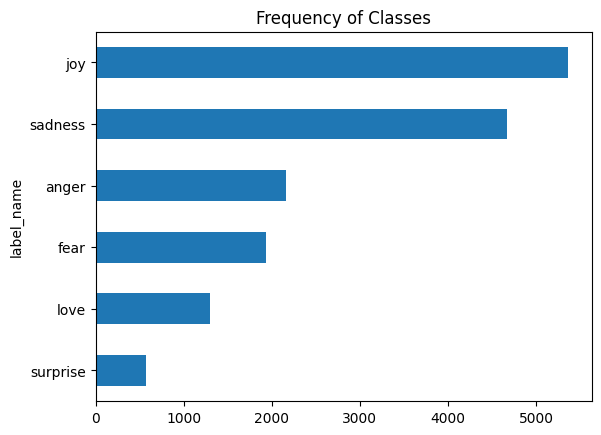

In [44]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

## How long are our Tweets?

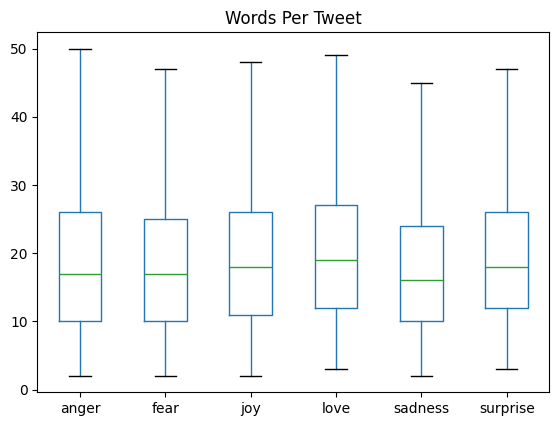

In [45]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, 
           showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

## From Text to Tokens - Sub Word Tokenization

In [46]:
emotions.reset_format()

In [47]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [48]:
df.head(2)

,text,label,label_name,Words Per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21


In [49]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [50]:
# Checking with sample
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [51]:
# Now that we have the input_ids, we can convert them back into tokens by using the tokenizer’s convert_ids_to_tokens() method
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [52]:
# The AutoTokenizer class has a convert_tokens_to_string() method for doing just that, so let’s apply it to our tokens
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [53]:
tokenizer.model_max_length

512

In [54]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

## Tokenizing the whole dataset

In [55]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [56]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# Text Classifier

## SBERT Embedding

In [57]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [58]:
# Convert to Pandas DataFrames
df_train = pd.DataFrame(emotions['train'])
#df_valid = pd.DataFrame(emotions['validation'])
#df_test = pd.DataFrame(emotions['test'])

In [59]:
df_train = df_train.sample(2000)
df_train.head(1)

,text,label
10216,i wear this it is one of those rare occasions ...,1


In [60]:
# Text embedding
from sentence_transformers import SentenceTransformer
# Load a pre-trained SBERT model
model_name = 'paraphrase-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

In [61]:
# Function to obtain embeddings
def get_embeddings(texts):
    embeddings = model.encode(texts)
    return embeddings

# Apply the function to the "text" column in your DataFrame
df_train['text_embedding'] = df_train['text'].apply(get_embeddings)

In [62]:
df_train.head(2)

,text,label,text_embedding
10216,i wear this it is one of those rare occasions ...,1,"[-0.24261029, 0.19535953, 0.20098037, 0.432683..."
11861,i cant help but feel a bi jealous of their pro...,3,"[-0.39217776, 0.1713062, 0.05257176, -0.365530..."


In [63]:
# Split the data into features (X) and labels (y)
X = list(df_train['text_embedding'])
y = df_train['label']

In [64]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [65]:
# Create a multi-label logistic regression model
from sklearn.linear_model import LogisticRegression
multi_label_lr = LogisticRegression(multi_class='ovr', max_iter=3000)

# Train the model on the training set
multi_label_lr.fit(X_train, y_train)

LogisticRegression(max_iter=3000, multi_class='ovr')

In [66]:
# Make predictions on the test set
y_pred = multi_label_lr.predict(X_test)

In [67]:
# Calculate accuracy and display classification report
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 0.5825
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.62      0.58       123
           1       0.66      0.71      0.68       129
           2       0.43      0.32      0.37        31
           3       0.61      0.53      0.57        57
           4       0.54      0.47      0.50        45
           5       0.36      0.27      0.31        15

    accuracy                           0.58       400
   macro avg       0.53      0.49      0.50       400
weighted avg       0.58      0.58      0.58       400



## USE Embedding

In [70]:
# Convert to Pandas DataFrames
df_train = pd.DataFrame(emotions['train'])
df_train = df_train.sample(2000)
df_train.head(1)

,text,label
6413,i used to share my feeling and thought all to ...,2


In [95]:
import tensorflow as tf
import tensorflow_hub as hub

# Load the Universal Sentence Encoder Multilingual model from TensorFlow Hub
#module_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
module_url = "https://tfhub.dev/google/universal-sentence-encoder-lite/2"
embed = hub.load(module_url)

In [100]:
# Function to obtain embeddings for a given text
def get_embedding(text):
    embeddings = embed(sentences)
    return embeddings.numpy()

# Apply the function to the 'text' column and create a new 'text_embedding' column
#df_train['text_embedding'] = df_train['text'].apply(get_embedding)

## Transformers as feature extractors

In [37]:
#1.a Using pre-trained model
from transformers import TFAutoModel, AutoTokenizer
tf_model = TFAutoModel.from_pretrained(model_ckpt)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [38]:
#1.b Extracting Last hidden states
text = "this is a test"
inputs = tokenizer(text, return_tensors='tf')
inputs

{'input_ids': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[ 101, 2023, 2003, 1037, 3231,  102]])>, 'attention_mask': <tf.Tensor: shape=(1, 6), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1]])>}

In [39]:
outputs = tf_model(inputs)
outputs

TFBaseModelOutput(last_hidden_state=<tf.Tensor: shape=(1, 6, 768), dtype=float32, numpy=
array([[[-0.156513  , -0.18619666,  0.05277661, ..., -0.11881153,
          0.0662061 ,  0.54701537],
        [-0.35751367, -0.648356  , -0.06178995, ..., -0.3040195 ,
          0.35076845,  0.5220682 ],
        [-0.27718437, -0.44594452,  0.18184265, ..., -0.09477907,
         -0.00757394,  0.99582815],
        [-0.28408557, -0.39167672,  0.37525564, ..., -0.21505764,
         -0.11725163,  1.0526478 ],
        [ 0.26608288, -0.509364  , -0.3180135 , ..., -0.42029774,
          0.01444202, -0.21489538],
        [ 0.9440616 ,  0.01117214, -0.47139424, ...,  0.14394712,
         -0.72878313, -0.16194952]]], dtype=float32)>, hidden_states=None, attentions=None)

In [40]:
outputs.last_hidden_state.shape

TensorShape([1, 6, 768])

In [41]:
outputs.last_hidden_state[:, 0].numpy()

array([[-1.56513005e-01, -1.86196655e-01,  5.27766123e-02,
        -1.06344059e-01, -1.31630674e-02, -2.69437909e-01,
         9.22702178e-02,  1.58652782e-01, -9.86746550e-02,
        -2.95723140e-01, -1.37878478e-01, -3.80609855e-02,
        -5.36169782e-02,  1.30451798e-01,  3.97127829e-02,
         8.68933052e-02,  2.50871032e-02,  8.61760974e-03,
         2.52425611e-01, -1.36781469e-01, -1.21373095e-01,
        -1.38957769e-01, -1.34264559e-01, -9.08442587e-02,
         3.05092223e-02, -3.86192948e-02,  1.14854768e-01,
        -5.79963475e-02,  1.01310536e-01,  9.79197398e-02,
         3.87435406e-03,  1.19504750e-01, -6.63392395e-02,
        -2.12569814e-02,  1.30903557e-01,  2.65199598e-02,
         2.36243710e-01,  5.02197146e-02,  1.35027841e-02,
        -2.13795286e-02, -8.83227736e-02, -9.83600914e-02,
         2.26749182e-01, -2.49402765e-02, -1.62608743e-01,
        -8.37869793e-02, -1.96290505e+00, -1.45407006e-01,
        -1.55823022e-01, -3.54869574e-01, -4.59713154e-0

In [42]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [43]:
emotions_encoded.reset_format()

def extract_hidden_states(batch):
    # First convert text to tokens
    inputs = tokenizer(batch["text"], padding=True, 
                       truncation=True, return_tensors='tf')
    # Extract last hidden states
    outputs = tf_model(inputs)
     # Return vector for [CLS] token
    return {"hidden_state": outputs.last_hidden_state[:,0].numpy()}

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True, batch_size=64)

C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [44]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [45]:
#1.c Creating feature matrix
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [46]:
#Training with classifier
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [55]:
# Make predictions on the validation set
y_preds = lr_clf.predict(X_valid)

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, figsize=(15, 15)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [57]:
df_eval = pd.DataFrame({'y_true': y_valid, 'y_preds': y_preds})
df_eval['y_true'] = (df_eval['y_true'].apply(label_int2str))
df_eval['y_preds'] = (df_eval['y_preds'].apply(label_int2str))

C:\Users\Abhishek_Jaiswal\AppData\Local\Temp\ipykernel_13608\3227192740.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


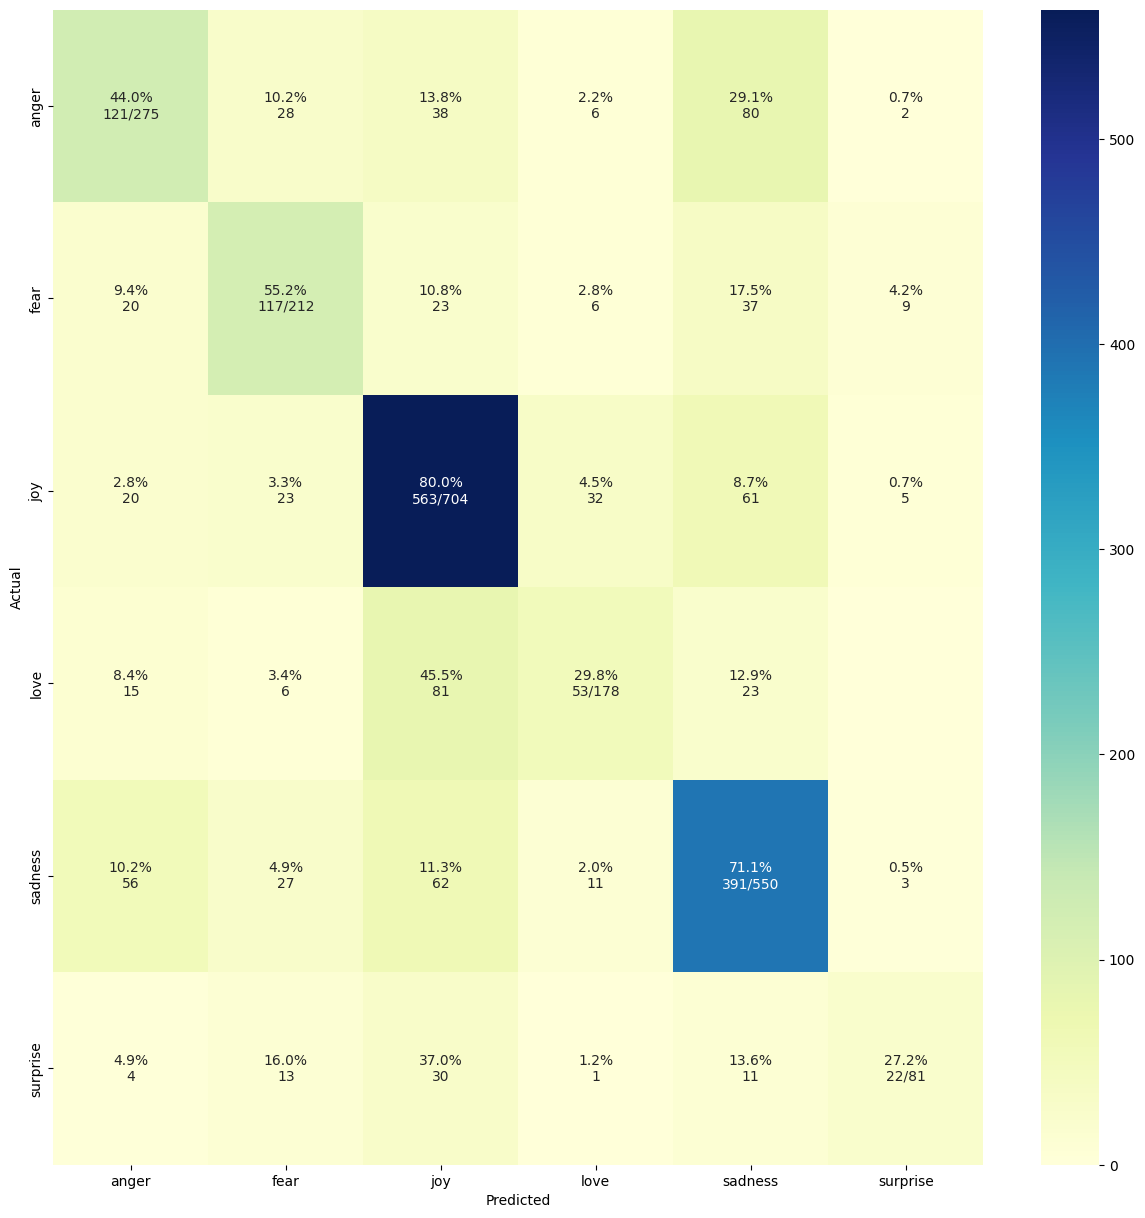

In [58]:
plot_cm(df_eval['y_true'], df_eval['y_preds'])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_eval['y_preds'], df_eval['y_true']))

# Fine-tuning Transformers

In [60]:
#2.a Loading a pretrained model
from transformers import TFAutoModelForSequenceClassification
tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [61]:
tf_model.summary()

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
 dropout_58 (Dropout)        multiple                  0         
                                                                 
Total params: 66958086 (255.42 MB)
Trainable params: 66958086 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [68]:
import tensorflow as tf
tf.keras.utils.plot_model(tf_model, show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [69]:
# The column names to convert to TensorFlow tensors
from transformers import DataCollatorWithPadding

tokenizer_columns = tokenizer.model_input_names

# Define a batch size
batch_size = 64

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(columns=tokenizer_columns, 
                                                           label_cols=["label"], shuffle=True,
                                                           batch_size=batch_size,
                                                           collate_fn=data_collator)
tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(columns=tokenizer_columns, 
                                                               label_cols=["label"], shuffle=False,
                                                               batch_size=batch_size,
                                                               collate_fn=data_collator)

tf_train_dataset

C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv\Lib\site-packages\datasets\arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 87), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 87), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
import tensorflow as tf

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=1)

Epoch 1/2

 71/250 [=======>......................] - ETA: 41:36 - loss: 1.0420 - sparse_categorical_accuracy: 0.6380

In [ ]:
#Saving the model
#tf.keras.models.save_model(tf_model, filepath='my_model', overwrite=True, save_format='tf')

In [ ]:
loss, eval_accuracy = tf_model.evaluate(tf_eval_dataset)
print("Loss: {}\t Test Accuracy: {}".format(loss, eval_accuracy))

## Prediction on evaluation set

In [ ]:
output_logits = tf_model.predict(tf_eval_dataset).logits
pred_labels = np.argmax(output_logits, axis=-1)

In [ ]:
emotions_encoded.set_format("pandas") 
cols = ["text", "label"]
df_test = emotions_encoded["validation"][:][cols] 
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = pred_labels
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [ ]:
df_test.sample(4)

In [ ]:
confusion_matrix(df_test.label, df_test.predicted_label)

In [ ]:
plot_cm(df_test.label, df_test.predicted_label)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_test.predicted_label, df_test.label))

In [ ]:
#https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers